# <span style='color:Blue'> PROJET 2 </span>

Je vous invite à suivre les étapes de construction de la base de donnée "T" dans le notebook appelé "construction_BDD_T.ipynb". Dans le cadre de ce projet 2, nos analyses n'utilisent que la base de donnée T. 

Le projet 2 est composé de 4 parties. Vous pouvez executés ces parties de façon indépendante si vous le vouliez car à chaque fois on réutilise (réimporte) la base de donnée T.

LA PARTIE 1 consiste à faire une analyse univariée et bivariée appuyée par des graphiques.

LA PARTIE 2 consiste à faire une analyse multivariée (ACP) nous permettant d'étudier la corrélation entre les variables quantitatives de la base de donnée T.

LA PARTIE 3 a pour but de prédire le niveau de calorie (calorie_level) en utilisant une régression logistique multinomiale.

Enfin, LA PARTIE 4 se fixe pour objectif de prédire une variable "rating binaire" en fonction d'autres variables en utilisant la technique du random forests (forêts aléatoires). 

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import model_selection
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# ACP
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, accuracy_score

# afficher les graphiques dans un notebook
%matplotlib inline

#Test de chi-2
from scipy.stats import chi2_contingency

#Appel des fonctions de 'utiles.py'
import utiles

In [40]:
# Gestion des Warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## <span style='color:Blue'> PARTIE 1 : Analyse - Univariée - Bivariée </span>

**OBJECTIF 1 :** L'objectif de cette première partie est de réaliser une analyse univariée et bivariée de quelques variables. Il sera également question de les représenter graphiquement.

### <span style='color:Blue'> 1. Importer la base de donnée T  </span>

In [41]:
T = pd.read_csv("T.csv",  index_col=0)   
T.head(1)

,id,contributor_id,name,minutes,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,calories,calorie_level,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating,rating_bin
0,424415,496803,aromatic basmati rice rice cooker,61,3,6,5,0,228.2,0,2,1,2,8,9,15,4,1


In [42]:
print("La base de donnée T comporte", T.shape[0], "recettes", "et", T.shape[1], "variables.")

La base de donnée T comporte 177224 recettes et 18 variables.


In [43]:
print("La base de donnée T comporte", T.isnull().sum().sum(), "donnée manquante.")

La base de donnée T comporte 0 donnée manquante.


### <span style='color:Blue'> 2. Analyse univariée  </span>

In [44]:
T_continue = T.drop(['id', 'contributor_id', 'name', 'minutes', 'minutes_discrt', 'n_steps', 
                         'n_ingredients_discrt', 'calorie_level', 'rating', 'rating_bin'], axis=1)
round(T_continue.describe(), 1)

,n_ingredients,calories,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates
count,177224.0,177224.0,177224.0,177224.0,177224.0,177224.0,177224.0,177224.0
mean,9.0,458.3,34.7,43.8,80.3,28.3,34.4,15.0
std,3.2,1247.3,63.6,88.4,895.9,99.8,54.1,91.1
min,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7.0,177.5,9.0,7.0,9.0,5.0,7.0,4.0
50%,9.0,310.7,20.0,22.0,24.0,15.0,19.0,9.0
75%,11.0,504.4,40.0,51.0,64.0,32.0,51.0,16.0
max,20.0,434360.2,4331.0,6875.0,362729.0,14664.0,6552.0,36098.0


### Diagramme circulaire

Dans un premier temps, on trace un camembert des variables discrétisées : "minutes_discrt" et "n_ingredients_discrt".

Text(0.5, 1.0, 'nbre ingredients discrètisées')

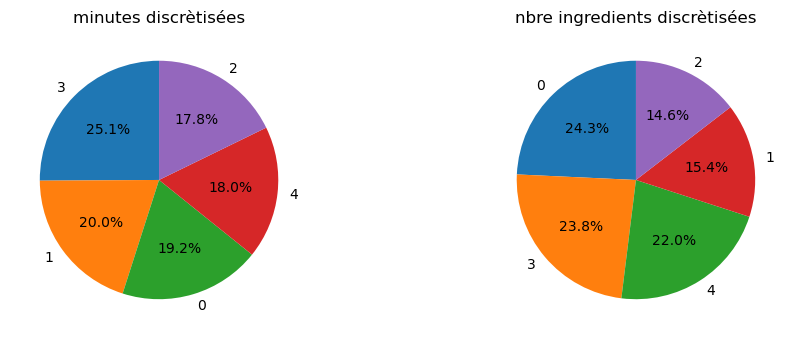

In [45]:
plt.figure(figsize=(10, 8))      #dimension de la figure
plt.subplots_adjust(wspace=0.6) #espace separant les deux graphiques 

#Figure 1 :
plt.subplot(1, 2, 1)
plt.pie(T['minutes_discrt'].value_counts(), labels =T['minutes_discrt'].unique(), autopct='%1.1f%%', shadow=False, startangle=90)

plt.title('minutes discrètisées')

#Figure 2
plt.subplot(1, 2, 2)
plt.pie(T['n_ingredients_discrt'].value_counts(), labels =T['n_ingredients_discrt'].unique(), autopct='%1.1f%%', shadow=False, startangle=90)
plt.title('nbre ingredients discrètisées')

Tel qu'on l'a voulu, il ressort de ces 2 graphiques que toutes les classes ont à peu-près la même proportion.

### Diagramme en barre : "calorie level"

On trace le diagramme en barre des variables catégorielles "calorie_level".

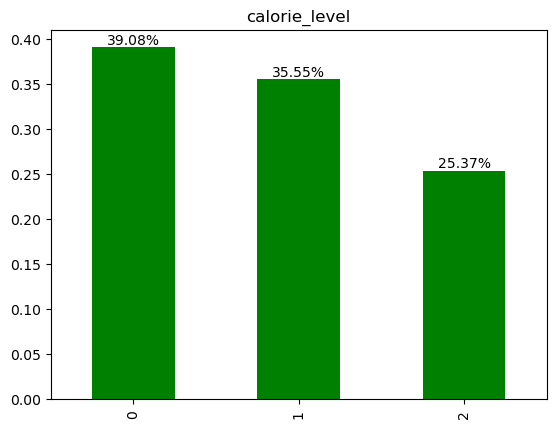

In [46]:
# Proportion de chaque classe de "calorie_level"
value_countsC = T['calorie_level'].value_counts()
proportionsC = value_countsC / value_countsC.sum()

utiles.diagramme_en_barre(proportionsC, "calorie_level", color='green')

In [47]:
print(round((proportionsC.loc[0] + proportionsC.loc[1])*100, 2),"%", "des recettes ont un niveau de calorie inférieur ou égal à 1.")
print("Seulement le quart des recettes ont un niveau de calorie égal à 2.")

74.63 % des recettes ont un niveau de calorie inférieur ou égal à 1.
Seulement le quart des recettes ont un niveau de calorie égal à 2.


### Diagramme en barre : "rating" et "rating binaire"

In [48]:
# Proportion des modalités de "rating"
value_countsR = T['rating'].value_counts()
proportionsR = value_countsR / value_countsR.sum()

# Proportion des modalités de "rating binaire"
value_countsR_bin = T['rating_bin'].value_counts()
proportionsR_bin = value_countsR_bin / value_countsR_bin.sum()

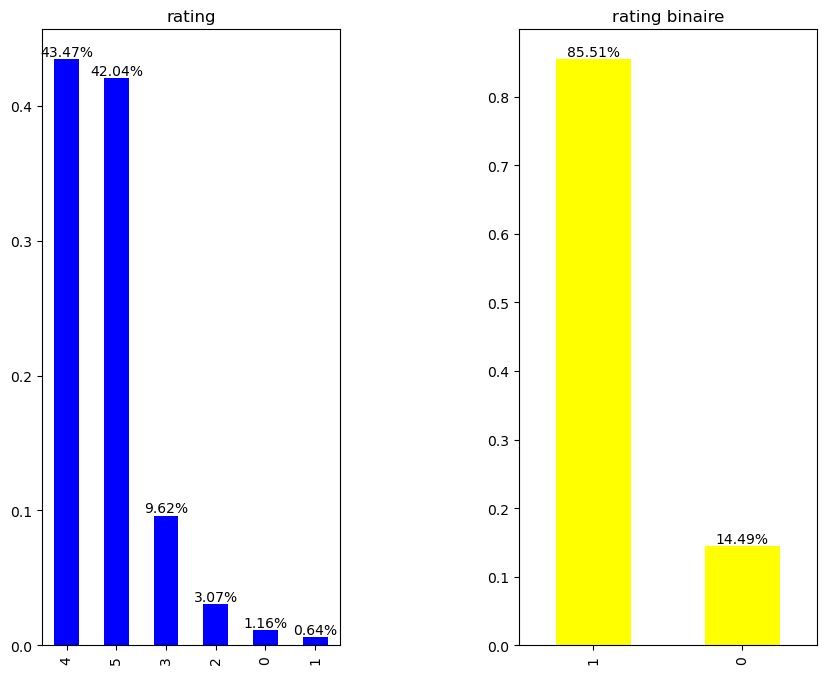

In [49]:
plt.figure(figsize=(10, 8)) 
plt.subplots_adjust(wspace=0.6)

# Figure 1 : rating
plt.subplot(1, 2, 1)
utiles.diagramme_en_barre(proportionsR, "rating", color='blue')

# Figure 1 : rating
plt.subplot(1, 2, 2)
utiles.diagramme_en_barre(proportionsR_bin, "rating binaire", color='yellow')

rating binaire est une nouvelle variable dont la construction a été expliquée dans la construction de la base de donnée T. La somme des modalités 0, 1, 2 et 3 représente 14,49% et celle des modalités 4 et 5 représente 85,51%.

### Boxplot des variables quantitatives 

Comme la variable continue "minutes" a fait l'objet d'une étude dans le projet 1,  j'ai décidé de ne pas l'inclure.

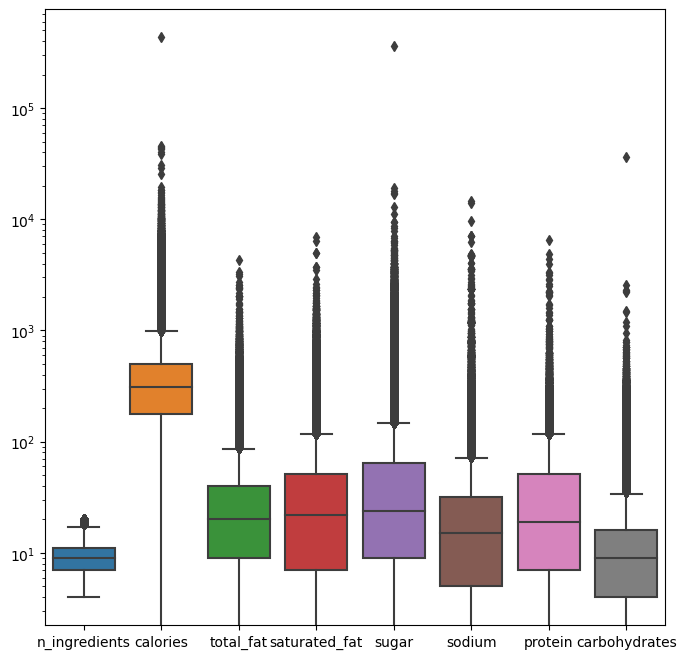

In [50]:
plt.figure(figsize=(8, 8))  
sns.boxplot(data=T.drop(['id', 'contributor_id', 'name', 'minutes', 'minutes_discrt', 'n_steps', 
                         'n_ingredients_discrt', 'calorie_level', 'rating', 'rating_bin'], axis=1))
# transformation logarithmique 
plt.yscale('log')

Le graphique ci-dessus nous permet de voir que la médiane du 'calories' est la plus grande de toutes les variables et celle du 'nombre d'ingrédients' est la plus faible. La médiane des variables 'total_fat', 'satured_fat', 'sugar' et 'protein' sont à peu-près égale.

Ce graphique nous permet également de voir que toutes les variables comportent des grandes valeurs excepté le nombre d'ingrédients.

### <span style='color:Blue'> 2. Analyse Bivariée </span>

### Lien entre les variables catégorielles "calorie_level" et "rating"

On effectue un test de Khi-2 afin d'étudier ce lien.

Hypothèses : 
H0 : calorie_level et rating sont indépendantes si p-value > 5%
H1 : calorie_level et ratings ne sont pas indépendantes si p-value < 5%

In [51]:
#Table de contingence
contingCalorieRating = pd.crosstab(T['calorie_level'], T['rating'])

#Test de Khi-2
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(contingCalorieRating)
print("Le niveau de calorie et la note attribuée à la recette sont dépendantes car la p-value =", p_value, "est inférieure à 0.05")

Le niveau de calorie et la note attribuée à la recette sont dépendantes car la p-value = 9.260733326599634e-10 est inférieure à 0.05


### Lien entre les variables catégorielles "n_ingredients_discret" vs "rating"

On effectue aussi un test de Chi-2.

Hypothèses
H0 : n_ingredients_discret et ratings sont indépendantes si p-value > 5%
H1 : n_ingredients_discret et ratings ne sont pas indépendantes si p-value < 5%

In [52]:
#Table de contingence
contingIngredientRating = pd.crosstab(T['n_ingredients_discrt'], T['rating'])

#Test de Khi-2
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(contingIngredientRating)
print("Le nombre d'ingredients et la note attribuée à la recette sont dépendantes car la p-value =", p_value,"est < à 0.05")

Le nombre d'ingredients et la note attribuée à la recette sont dépendantes car la p-value = 6.404839812909469e-07 est < à 0.05


### Lien entre la variable quantitative 'calories' et catégorielle 'rating'

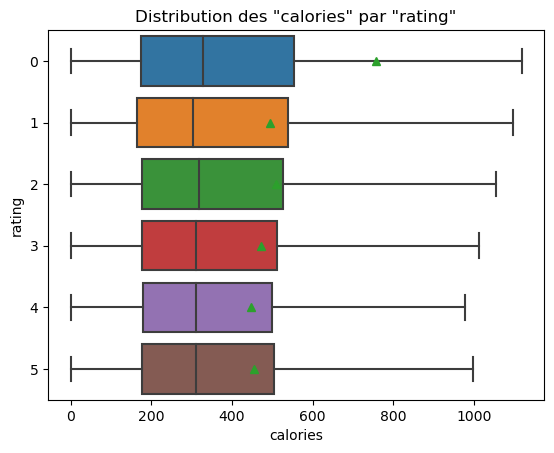

In [53]:
sns.boxplot(data=T, x='calories', y='rating', orient='h', showfliers=False, showmeans=True)
plt.title('Distribution des "calories" par "rating"')
plt.show()

Le graphique ci-dessus nous permet de voir que la médiane de tous les groupes est presque identique.
La moyenne de tous les groupes est proche exceptée celle dont la note des récettes est nulle.

## <span style='color:Blue'> PARTIE 2 : Analyse Multivariée (Analyse en Composante Principale) </span>

OBJECTIF DE L'ANALYSE EN COMPOSANTES PRINCIPALES (ACP) : L'ACP nous permettra d'étudier la corrélation entre les variables quantitatives. Il nous permettra d'identifier également les récettes ayant les mêmes caractéristiques. 
Les recettes similaires auront une faible distance entre elles dans la représentation graphique des récettes.

On réalise deux ACP, j'ai jugé utile de faire des fonctions qui nous permettent de tracer les graphiques (cercle de corrélation, graphique des observations). 

In [54]:
T = pd.read_csv("T.csv",  index_col=0)

### <span style='color:Blue'> 1. Analyse en Composantes Principales 1  </span>

In [55]:
dataACP1 = T.drop(columns=['id', 'calorie_level', 'n_steps', 'minutes', 'rating', 'contributor_id', 'name', 'minutes_discrt', 'n_ingredients_discrt', 'rating_bin'], axis = 1)
dataACP1.head(2)

,n_ingredients,calories,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates
0,5,228.2,2,1,2,8,9,15
1,12,249.4,16,27,92,8,11,11


dataACP1 comporte le même nombre d'observations que notre base de donnée de travail T excepté les variables catégorielles et la variable "minutes". Donc, on a 9 variables en moins (voir drop juste au dessus).

Les 8 variables intervenant dans l'ACP sont : n_ingredients, calories, total_fat, saturated_fat, sugar, sodium, protein, et carbohydrates.

### Standardisation des variables

La standardisation de nos variables nous permet de rémedier au problème d'échelle et à l'influence des outliers, s'il en existe. Elle nous rassure aussi de la contribution équitable des variables dans la construction des composantes principales.
Les variables standardisées ont une moyenne nulle et un ecart-type égal à 1.
En dépit de la standardisation, vous decouvrirez plus bas une recette atypique.

In [56]:
scaler = StandardScaler()
scaler.fit(dataACP1)
X1 = scaler.transform(dataACP1)

In [57]:
# Instanciation du modele d'ACP
mypca = PCA()

# Modele
mypca.fit(X1)

PCA()

In [58]:
# valeurs propres
n = X1.shape[0] 
eigal = ((n-1)/n)*mypca.explained_variance_
print("La somme des valeurs propres vaut", np.round(sum(eigal)), ". C'est exactement le nombre de variables intervenues dans l'ACP.")

La somme des valeurs propres vaut 8.0 . C'est exactement le nombre de variables intervenues dans l'ACP.


In [59]:
# Pourcentage de variance expliquée par chacune des composantes sélectionnées.
print(mypca.explained_variance_ratio_)

[4.54864968e-01 2.23291892e-01 1.26135898e-01 1.13346560e-01
 6.70871658e-02 1.31979415e-02 1.99648786e-03 7.90870587e-05]


In [60]:
# Pourcentage de la variance expliquée par chacune des composantes sélectionnées
print(mypca.singular_values_)

[803.05909673 562.6557191  422.8882443  400.87634672 308.40824731
 136.79157821  53.20342586  10.58909812]


In [61]:
# Tableau recapitulatif de "Dimension", "Variance expliquée", "%Variance expliquée" et "%variance cumulée"
eig = pd.DataFrame(
    {
        "Composante" : ["Comp" + str(x + 1) for x in range(8)], 
        "Variance expliquée" : np.round(mypca.explained_variance_),
        "% variance expliquée" : np.round(mypca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(mypca.explained_variance_ratio_) * 100)
    })

In [62]:
print(eig)

  Composante  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Comp1                 4.0                  45.0                   45.0
1      Comp2                 2.0                  22.0                   68.0
2      Comp3                 1.0                  13.0                   80.0
3      Comp4                 1.0                  11.0                   92.0
4      Comp5                 1.0                   7.0                   98.0
5      Comp6                 0.0                   1.0                  100.0
6      Comp7                 0.0                   0.0                  100.0
7      Comp8                 0.0                   0.0                  100.0


In [63]:
print("On constate que les 2 premières composantes nous rapportent", eig.loc[1][3], "% de la variance expliquée. Très bien !")

On constate que les 2 premières composantes nous rapportent 68.0 % de la variance expliquée. Très bien !


### Diagramme en barre des composantes principales de l'ACP 1

On fait appel à la fonction "eigplot" de "utiles.py"

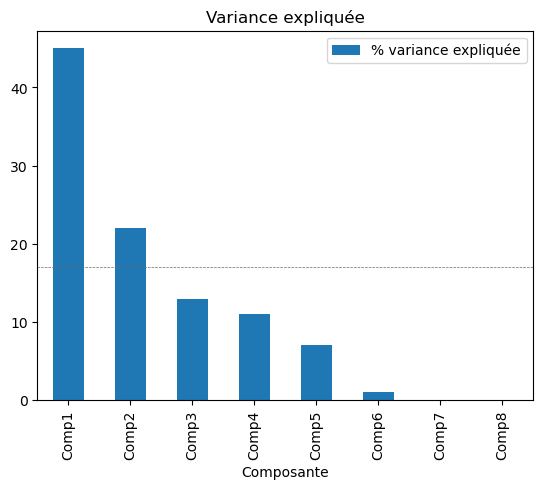

In [64]:
utiles.eigplot(eig)

### Coordonnées Factorielles 

La représentation graphique des "variables" en l'occurence le cercle de corrélation s'effectue grâce aux coordonnées factorielles.

In [65]:
n = X1.shape[0] # nb individus
p = X1.shape[1] # nb variables
columns = ['n_ingredients', 'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
eigval = (n-1) / n *mypca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval)                 # racine carrée des valeurs propres
corvar = np.zeros((p,p))                      # matrice vide pour stocker les coordonnées factorielles

for k in range(p):
    corvar[:,k] = mypca.components_[k,:] * sqrt_eigval[k]

# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({
                        'id': columns, 
                        'Comp1': corvar[:,0], 
                        'Comp2': corvar[:,1]})
coordvar

,id,Comp1,Comp2
0,n_ingredients,0.074866,-0.134387
1,calories,0.961201,0.262690
2,total_fat,0.707085,-0.606558
3,sugar,0.661455,-0.617287
4,sodium,0.782509,0.612595
5,protein,0.302768,-0.271844
6,saturated_fat,0.627383,-0.425448
7,carbohydrates,0.821169,0.565805


### Représentation graphique : cercle de corrélation de l'ACP 1

On fait appel à la fonction "plotcerclecorrelation" de "utiles.py".

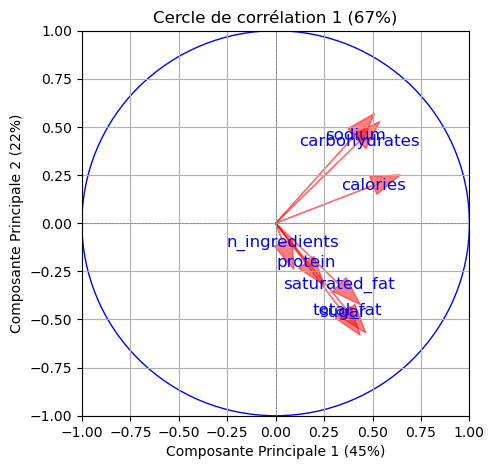

In [66]:
components = mypca.components_
utiles.plotcerclecorrelation(mypca.components_, columns, eig)

On commentera le cercle de corrélation de l'ACP2 réalisé plus bas.

### Représentation graphique des observations de l'ACP1 (sans id)

Afin de tracer nos observations (nos récettes plutôt), il nous faut d'abord déterminer les coordonnées factorielles de chaque récette.

In [67]:
#Coordonnées Factorielles
WGI_pca = mypca.transform(X1)

# Transformation des Coordonnées Factorielles en DataFrame pandas
WGI_pca_df = pd.DataFrame({
    "Comp1" : WGI_pca[:,0], 
    "Comp2" : WGI_pca[:,1],
    "id" : T["id"],
})
# Aperçu
WGI_pca_df.head(4)

,Comp1,Comp2,id
0,-0.722653,0.696233,424415
1,-0.410870,0.261234,146223
2,0.042761,-0.390560,312329
3,-0.749602,0.448227,74301


<Figure size 800x800 with 0 Axes>

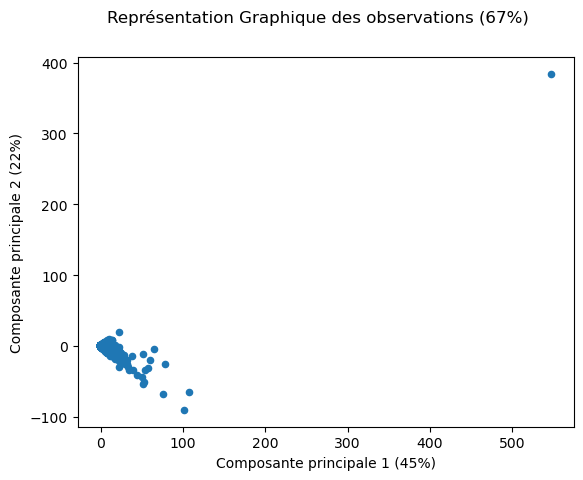

In [68]:
# On fait appel à la fonction "plot_observations_sansid" de "utiles"
percentC1 = eig.loc[0][2] # contribution en % de la premiere composante 
percentC2 = eig.loc[1][2] # contribution en % de la deuxiime composante

utiles.plot_observations_sansid(WGI_pca_df, percentC1, percentC2)

Dans la representation graphique des recettes ci-dessus, on constate qu'une recette a un comportement ATYPIQYE (en haut à droite). Quel est son identifiant ? Nous devons retracer ce même graphique en affichant les 'id' des recettes.

### Représentation graphique des observations (avec id) de l'ACP 1

La représentation graphique des observations avec les "id" étant chronophage, nous avons donc décider de n'afficher que 
que les id dont les coordonnées factorielles respectent une certaine condition.

Cette recette atypique porte l'identifiant numéro 193435 et la personne qui l'a soumise s'appelle 'tennessee moonshine'. 
Elle se caractérise par ses proportions anormales (T[T['id']==193435]) de calories, sodium, protein, carbohydrates, sugar, etc...Nous allons donc la supprimer et refaire notre Analyse en Composantes Principale.

<Figure size 800x800 with 0 Axes>

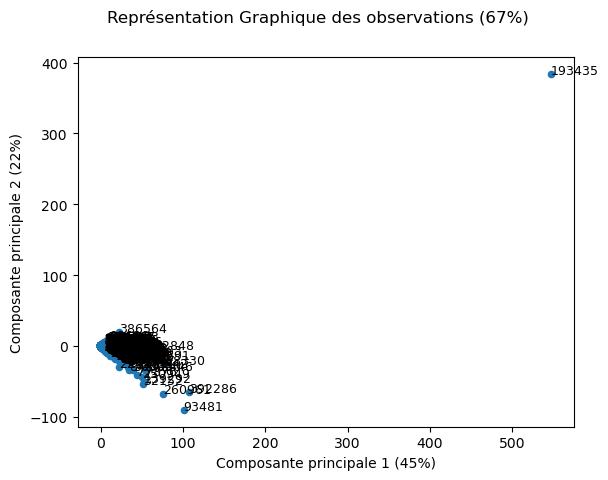

In [69]:
# On fait appel à la fonction "plot_observations_avecid" de "utiles"
utiles.plot_observations_avecid(WGI_pca_df, percentC1, percentC2)

In [70]:
# Aperçu de cette récette Atypique
T[T['id']==193435]

,id,contributor_id,name,minutes,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,calories,calorie_level,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating,rating_bin
54980,193435,374913,tennessee moonshine,20,0,3,5,0,434360.2,2,1293,590,362729,1324,3961,36098,0,0


In [71]:
# coordonnées factorielles de la recette ATYPIQUE
WGI_pca_df[WGI_pca_df['id'] == 193435]

,Comp1,Comp2,id
54980,547.161819,384.110197,193435


### <span style='color:Blue'> Suppression de la récette atypique "193435"  </span>

On supprime de la base de donnée "T" la récette atypique décélée grâce à l'ACP1.

In [72]:
# On renomme la base de donnée T en Tnew
Tnew = T

In [73]:
Tnew['id'] = Tnew['id'].astype(int)

In [74]:
index_id193435 = Tnew[Tnew['id']==193435].index      #l'index de la récette atypique à supprimer
Tnew.drop(index_id193435, inplace = True)

In [75]:
Tnew.shape  # une observation en moins

(177223, 18)

### <span style='color:Blue'> 2. Analyse en Composantes Principales 2  </span>

On refait l'ACP sans cette récette atypique. La base de donnée de notre nouvelle ACP est appelée dataACP2.

In [76]:
# On reprécise la suppression des variables catégorielles et la variable "minutes" dont on n'a pas besoin dans notre ACP.
dataACP2 = Tnew.drop(columns=['id', 'calorie_level', 'n_steps', 'minutes', 'rating', 'rating_bin', 'contributor_id', 'name', 'minutes_discrt', 'n_ingredients_discrt'], axis = 1)

In [77]:
dataACP2.head(1)

,n_ingredients,calories,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates
0,5,228.2,2,1,2,8,9,15


In [78]:
print("La base de donnee dataACP2 a", dataACP2.shape[0], "observations au lieu de", dataACP1.shape[0],", une observation en moins.")

La base de donnee dataACP2 a 177223 observations au lieu de 177224 , une observation en moins.


### Standardisation des variables

In [79]:
features = ["n_ingredients", "calories", "total_fat", "saturated_fat", "sugar", "sodium", "protein", "carbohydrates"]
target = T['calorie_level']

In [80]:
features = dataACP2[features]

In [81]:
scaler = StandardScaler()
scaler.fit(features)
X2 = scaler.transform(dataACP2)

In [82]:
mypca2 = PCA()

In [83]:
Comp1 = mypca2.fit_transform(X2)[:,0]
Comp2 = mypca2.fit_transform(X2)[:,1]
ldngs = mypca2.components_

In [84]:
scalePC1 = 1.0/(Comp1.max() - Comp1.min())
scalePC2 = 1.0/(Comp2.max() - Comp2.min())

In [85]:
#Pourcentage de variance expliquée par chacune des composantes sélectionnées.
print(mypca2.explained_variance_ratio_)

[5.34269023e-01 1.42352737e-01 1.18491307e-01 1.13818304e-01
 5.93807781e-02 1.92115863e-02 1.21817284e-02 2.94536706e-04]


In [86]:
# Pourcentage de la variance expliquée par chacune des composantes sélectionnées
print(mypca2.singular_values_)

[870.33216196 449.24985502 409.87202826 401.70856389 290.15360958
 165.03902448 131.41940339  20.43500499]


In [87]:
#tableau recapitulatif de "Dimension", "Variance expliquée", "%Variance expliquée" et "%variance cumulée"
eig2 = pd.DataFrame(
    {
        "Composante" : ["Comp" + str(x + 1) for x in range(8)], 
        "Variance expliquée" : mypca2.explained_variance_,
        "% variance expliquée" : np.round(mypca2.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(mypca2.explained_variance_ratio_) * 100)
    })
print(eig2)

  Composante  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Comp1            4.274176                  53.0                   53.0
1      Comp2            1.138828                  14.0                   68.0
2      Comp3            0.947936                  12.0                   80.0
3      Comp4            0.910552                  11.0                   91.0
4      Comp5            0.475049                   6.0                   97.0
5      Comp6            0.153694                   2.0                   99.0
6      Comp7            0.097454                   1.0                  100.0
7      Comp8            0.002356                   0.0                  100.0


### Diagramme en barre des composantes principales de l'ACP 2

On fait appel à la fonction "eigplot" de "utiles.py".

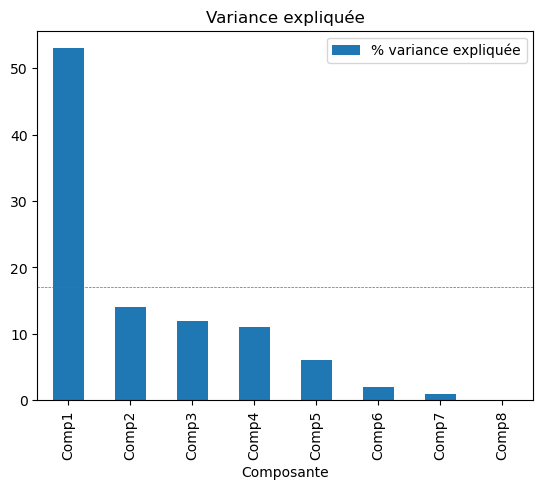

In [88]:
utiles.eigplot(eig2)

## Représentation graphique : cercle de corrélation de l'ACP 2

On réutilise la fonction "plotcerclecorrelation" de "utiles.py".

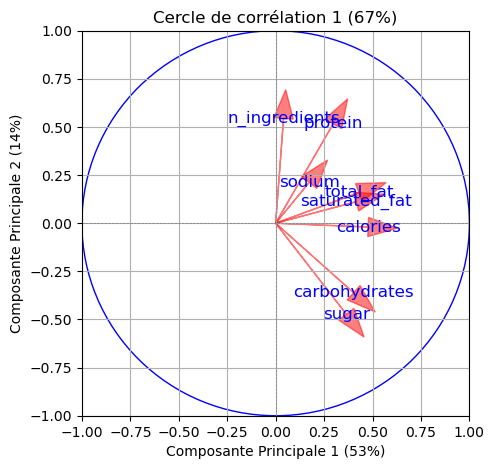

In [89]:
utiles.plotcerclecorrelation(mypca2.components_, features.columns, eig2)

Nous remarquons que les recettes contenant du sugar et du carbohydrates sont corrélées entre elles, également celles contenant du total_fat et saturated_fat.

La suppression de la récette ATYPIQUE "193435" nous a permis d'obtenir les bonnes coordonnées factorielles de nos variables et donc le bon cercle de corrélation. 

### Représentation graphique des observations de l'ACP 2 (sans id) 

In [90]:
#Coordonnées Factorielles
WGI_pca2 = mypca.transform(X2)

# Transformation en DataFrame pandas
WGI_pca_df2 = pd.DataFrame({
    "Comp1" : WGI_pca2[:,0], 
    "Comp2" : WGI_pca2[:,1],
    "id" : Tnew["id"],
})

# Résultat (premières lignes)
WGI_pca_df2.head(4)

,Comp1,Comp2,id
0,-0.884073,0.571720,424415
1,-0.493395,0.224352,146223
2,-0.127066,-0.547601,312329
3,-1.077021,0.187664,74301


<Figure size 800x800 with 0 Axes>

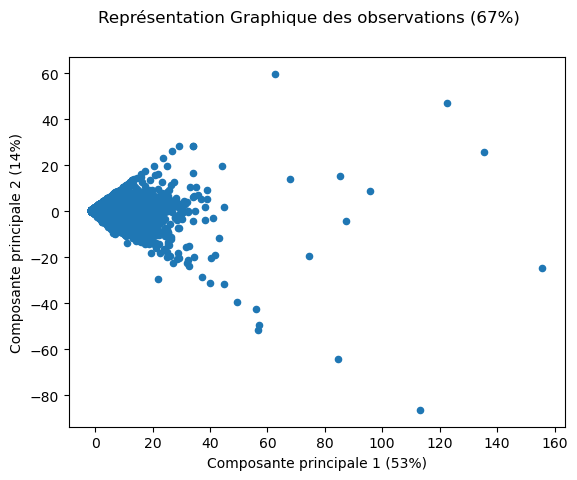

In [91]:
# On fait appel à la fonction "plot_observations_sansid" de "utiles"
percentC1 = eig2.loc[0][2] # contribution en % de la premiere composante 
percentC2 = eig2.loc[1][2] # contribution en % de la deuxiime composante
utiles.plot_observations_sansid(WGI_pca_df2, percentC1, percentC2)

Encore une fois, la suppression de cette seule récette ATYPIQUE nous a permis d'obtenir une représentation graphique d'observation plus juste.

### Représentation graphique des observations de l'ACP2 (avec id)

On fait appel à la fonction "plot_observations_avecid" de "utiles"

<Figure size 800x800 with 0 Axes>

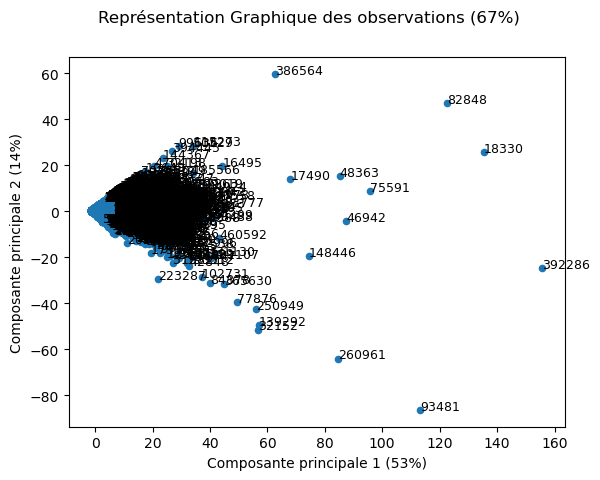

In [92]:
utiles.plot_observations_avecid(WGI_pca_df2, percentC1, percentC2)

La suppression de la seule recette atypique nous a permis d'avoir une bonne représentation graphique des recettes.
La contribution de la première composante principale est passé de 45 à 53%; la deuxième est passé de 22 à 14%.
Les récettes ayant les mêmes caractéristiques (ou similaires) sont proches, ont une faible distance qui les sépare.

### Aperçu de 3 récettes similaires (proches dans la figure)

Par exemple, affichons le contenu des récettes ci-dessous, proches entre elles dans le graphique et qui portent les identifiants suivantes : 48363, 75591 et 46942. Pour les 3 casn il s'agit des "gâteaux délicieux".

In [93]:
Tnew[Tnew['id']==48363]

,id,contributor_id,name,minutes,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,calories,calorie_level,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating,rating_bin
131081,48363,6258,easy easy friendship cake,75,4,7,10,2,40159.2,2,1922,1084,1024,2386,810,2275,4,1


In [94]:
Tnew[Tnew['id']==75591]

,id,contributor_id,name,minutes,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,calories,calorie_level,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating,rating_bin
132759,75591,30680,my mercy strawberry cake,60,3,11,9,2,42951.6,2,2343,2155,1544,2405,886,2315,0,0


In [95]:
Tnew[Tnew['id']==46942]

,id,contributor_id,name,minutes,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,calories,calorie_level,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating,rating_bin
165955,46942,57321,sinfully delicious hot chocolate mix,5,0,4,4,0,25712.6,2,1715,3532,11042,684,2238,948,4,1


### Représentation graphique : observations + variables

Text(0.5, 1.0, 'Graphique : Récettes + variables (67%)')

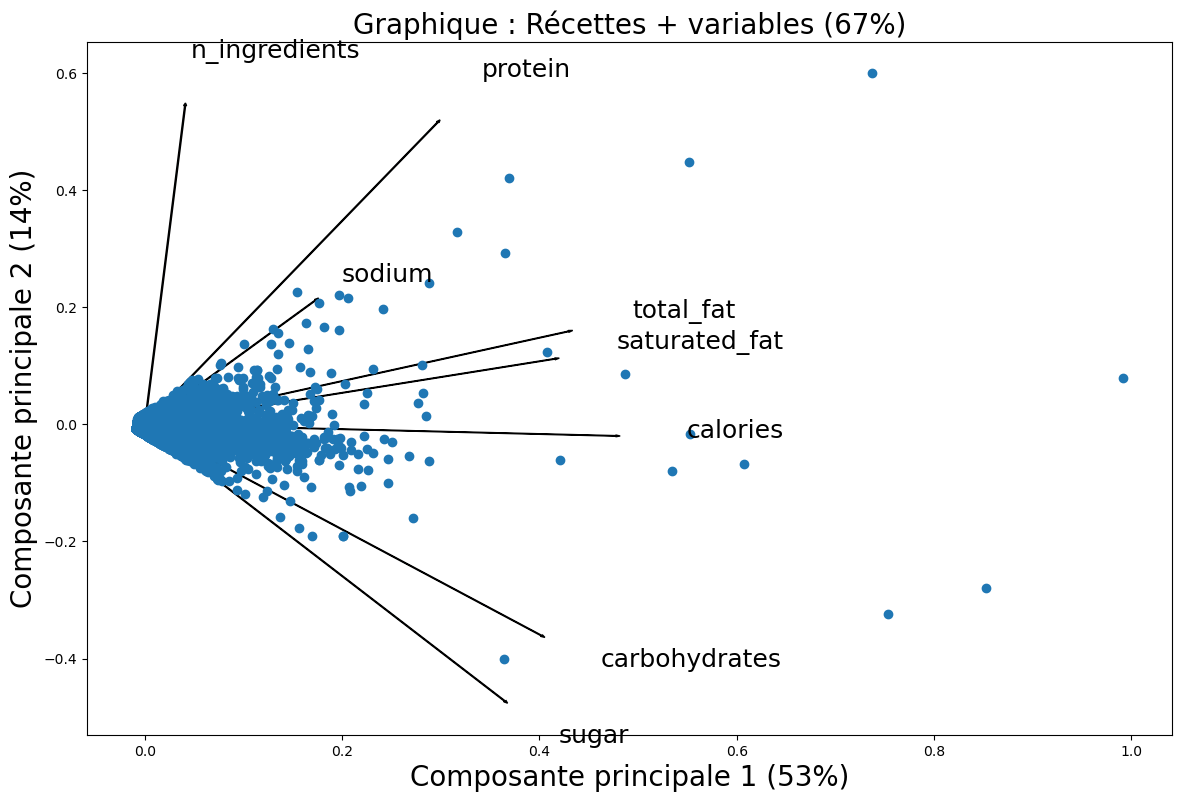

In [96]:
fig, ax = plt.subplots(figsize=(14, 9))
 
for i, feature in enumerate(features):
    ax.arrow(0, 0, ldngs[0, i], 
             ldngs[1, i])
    ax.text(ldngs[0, i] * 1.15, 
            ldngs[1, i] * 1.15, 
            feature, fontsize=18)
 
ax.scatter(Comp1 * scalePC1, Comp2 * scalePC2)
 
ax.set_xlabel('Composante principale 1 (53%)', fontsize=20)
ax.set_ylabel('Composante principale 2 (14%)', fontsize=20)
ax.set_title('Graphique : Récettes + variables (67%)', fontsize=20)

### Représentation graphique : observations + variables

L'exécution du code permettant d'obtenir le graphique est chronophage. 
Donc, j'ai préféré importer ce graphique qui est similaire au précédent.

In [97]:
from IPython.display import display, Image

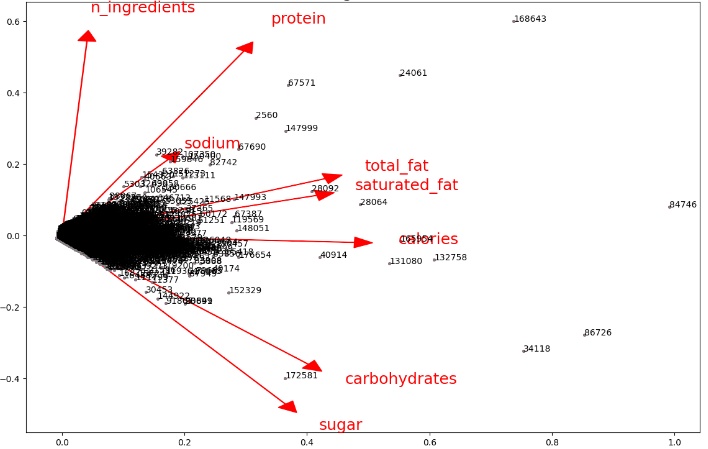

In [98]:
display(Image("C:/Users/PC/Documents/1. MS-BIGDATA/P1/Exploration des donnees/TP-Part1/tp_1_mahamat_atteib/graphique_obs_var_acp2.PNG"))

# <span style='color:Blue'> PARTIE 3 : Prédire le 'calorie_level' des récettes </span>

OBJECTIF : Dans cette troisième partie, on se fixe l'objectif de PREDIRE le niveau de calories (0, 1 et 2). 
On choisit d'utiliser la régression logistique multinomiale.

In [99]:
T = pd.read_csv("T.csv",  index_col=0)
T.head(1)

,id,contributor_id,name,minutes,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,calories,calorie_level,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating,rating_bin
0,424415,496803,aromatic basmati rice rice cooker,61,3,6,5,0,228.2,0,2,1,2,8,9,15,4,1


In [100]:
# Variable TARGET : calorie_level
y = T[['calorie_level']]

In [101]:
# Variables explicatives : on exclut quelques variables
X = T.drop(['calorie_level', 'calories', 'id', 'contributor_id', 'name', 'minutes', 'rating'], axis=1)
X.head(2)

,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating_bin
0,3,6,5,0,2,1,2,8,9,15,1
1,3,10,12,3,16,27,92,8,11,11,1


In [102]:
# Base de donnée "TRAIN" et "TEST"
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.2, random_state = 42)

## Modèle

In [103]:
# Instanciation du modèle
from sklearn import linear_model
lm = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [104]:
# Modèle
lm.fit(X_train, y_train)

c:\Users\PC\miniconda3\envs\bigdata\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(multi_class='multinomial')

## Prédiction

In [105]:
prediction_calories = lm.predict(X_test.values)

c:\Users\PC\miniconda3\envs\bigdata\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [106]:
y_pred = lm.predict(X_test)

## Matrice de confusion 

Text(0.5, 1.05, 'Matrice de Confusion')

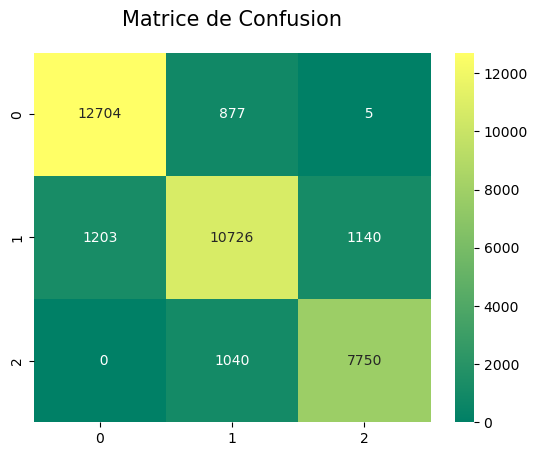

In [107]:
sns.heatmap(confusion_matrix(prediction_calories, y_test), annot=True, fmt='3.0f', cmap="summer")
plt.title('Matrice de Confusion', y=1.05, size=15)

In [108]:
print(metrics.classification_report(y_test, lm.predict(X_test.values)))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     13907
           1       0.82      0.85      0.83     12643
           2       0.88      0.87      0.88      8895

    accuracy                           0.88     35445
   macro avg       0.88      0.88      0.88     35445
weighted avg       0.88      0.88      0.88     35445



c:\Users\PC\miniconda3\envs\bigdata\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Score de prédiction 

In [109]:
accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f"Notre Accuracy vaut : {accuracy}")

Notre Accuracy vaut : 0.88


### Représentation Graphique : courbe ROC

La courbe ROC nous permet d'évaluer visuellement la qualité de notre prédiction.

In [110]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

c:\Users\PC\miniconda3\envs\bigdata\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


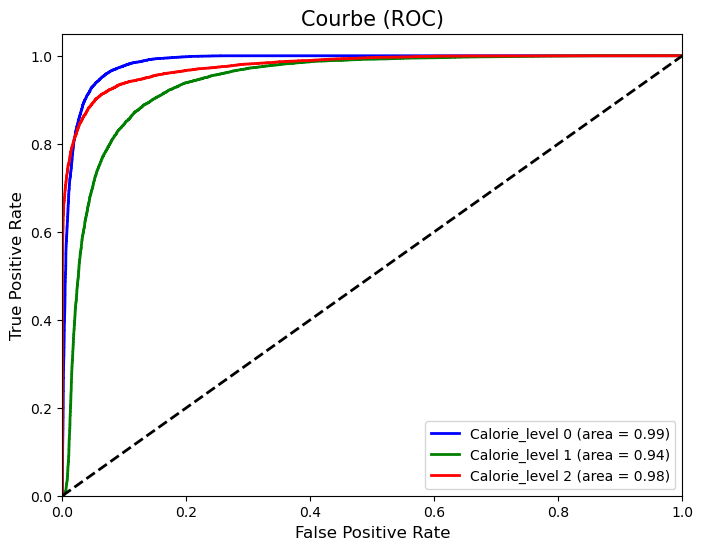

In [111]:
y_pred_prob = lm.predict_proba(X_test.values) 

# Labels
y_test_binary = label_binarize(y_test, classes=[0, 1, 2]) 

fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Tracer la courbe ROC
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Calorie_level {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Courbe (ROC)', fontsize=15)
plt.legend(loc='lower right')
plt.show()

Nos trois courbes ont toutes une aire proche de 1. Cela signifie que notre modèle a plutôt bien prédit le niveau de calorie.

# <span style='color:Blue'> PARTIE 4 : Prédire le 'rating binaire' des récettes </span>

OBJECTIF : On se fixe un autre objectif, celui de prédire la note des récettes ("rating binaire") en fonctin d'autres variables. 

On utilise "les forêts aléatoires", random forest. Le choix de cette technique n'est pas anodin car les modalités de notre variable target "rating binaire" sont fortement disproportionnés (voir le paragraphe Diagramme en barre : "rating" et "rating binaire" de la partie 1 sur l'analyse univariée). 

In [112]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import utiles

In [113]:
T = pd.read_csv("T.csv",  index_col=0)
T.head(1)

,id,contributor_id,name,minutes,minutes_discrt,n_steps,n_ingredients,n_ingredients_discrt,calories,calorie_level,total_fat,saturated_fat,sugar,sodium,protein,carbohydrates,rating,rating_bin
0,424415,496803,aromatic basmati rice rice cooker,61,3,6,5,0,228.2,0,2,1,2,8,9,15,4,1


In [114]:
# Variables explicatives de l'arbre de classification
X = T.drop(columns=['id', 'contributor_id', 'name', 'minutes', 'calorie_level', 'rating', 'rating_bin', 'n_ingredients'], axis = 1)

# Variable TARGET "rating_bin"
y = T.iloc[:,-1]

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
# Instanciation du modèle
modele_rf = RandomForestClassifier(
     n_estimators=100,
     criterion='gini',
     max_depth=None,
     min_samples_split=2,
     min_samples_leaf=1,
     min_weight_fraction_leaf=0.0,
     max_features='auto',
     max_leaf_nodes=None,
     min_impurity_decrease=0.0,
     bootstrap=True,
     oob_score=False,
     n_jobs=None,
     random_state=None,
     verbose=0,
     warm_start=False,
     class_weight=None,
     ccp_alpha=0.0,
     max_samples=None,)

In [117]:
modele_rf = modele_rf.fit(X_train, y_train)

c:\Users\PC\miniconda3\envs\bigdata\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [118]:
#prédiction sur la base 'train' et 'test'
y_predict_train = modele_rf.predict(X_train)
y_predict_test = modele_rf.predict(X_test)

In [119]:
# Score de classification
#import metrics 
from sklearn.metrics import accuracy_score
accuracy_score_test = accuracy_score(y_test, y_predict_test)
#accuracy_score_train = accuracy_score(y_train, y_predict_train)
print(accuracy_score_test)
#print(accuracy_score_train)

0.8572718295951474


In [120]:
# Score ROC
from sklearn.metrics import roc_auc_score
roc_auc_test = roc_auc_score(y_test, y_predict_test)
print(roc_auc_test)

0.500055172513558


In [121]:
roc_auc_train = roc_auc_score(y_train, y_predict_train)
print(roc_auc_train)

0.999672876811006


In [122]:
# Recall Score 
from sklearn.metrics import recall_score
recall_accuracy_test = recall_score(y_test, y_predict_test)
recall_accuracy_train = recall_score(y_train, y_predict_train)
print(recall_accuracy_test)
print(recall_accuracy_train)

0.9987178644223815
0.9999752326070983


In [123]:
# Matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de :{accuracy_score(y_test, y_predict_test)*100} %")

Le pourcentage de bien classés est de :85.72718295951474 %


### Variables importantes

In [124]:
print(modele_rf.feature_importances_)
print(X_train.columns)

[0.03097592 0.08998198 0.04867326 0.16969761 0.09864795 0.11081654
 0.13323884 0.11423577 0.11755253 0.08617961]
Index(['minutes_discrt', 'n_steps', 'n_ingredients_discrt', 'calories',
       'total_fat', 'saturated_fat', 'sugar', 'sodium', 'protein',
       'carbohydrates'],
      dtype='object')


In [125]:
# Afficher chaque variable avec son coef. d'importance dans l'ordre decroissant
pd.DataFrame(modele_rf.feature_importances_, index = X_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)

,importance
calories,0.169698
sugar,0.133239
protein,0.117553
sodium,0.114236
saturated_fat,0.110817
total_fat,0.098648
n_steps,0.089982
carbohydrates,0.086180
n_ingredients_discrt,0.048673
minutes_discrt,0.030976


### Représentation Graphique de variables importantes

On trace un diagramme en barre qui met range les variables par ordre d'importances, de la plus importante à la moins importante.

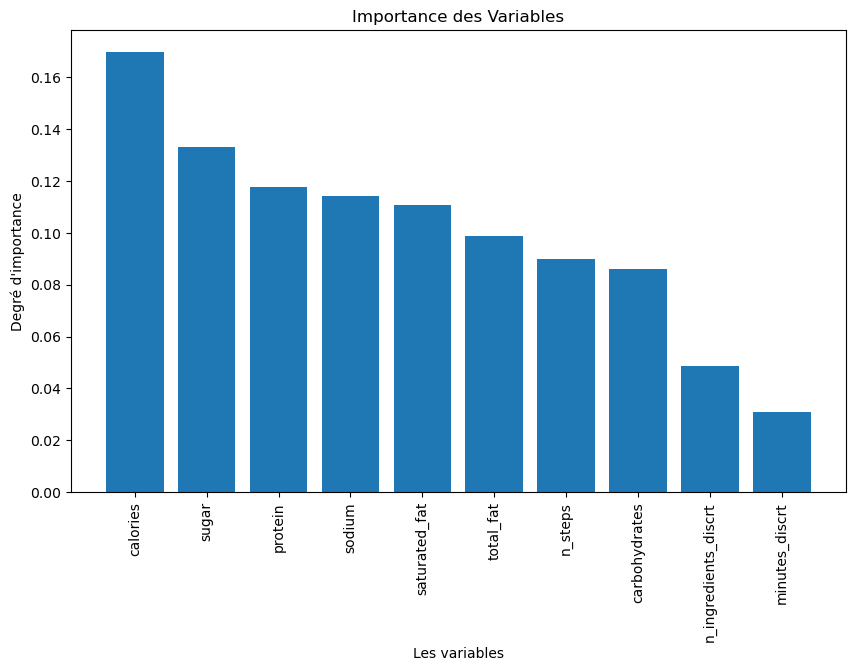

In [126]:
# Supposons que modele_rf.feature_importances_ contienne les importances des caractéristiques
feature_importances = modele_rf.feature_importances_

# Noms des variables (caractéristiques)
features = ['minutes_discrt', 'n_steps', 'n_ingredients_discrt', 'calories',
            'total_fat', 'saturated_fat', 'sugar', 'sodium', 'protein', 'carbohydrates']

# Associer les noms des caractéristiques avec leurs importances
features_importances = zip(features, feature_importances)

# Trier les caractéristiques par leur importance en ordre décroissant
sorted_features_importances = sorted(features_importances, key=lambda x: x[1], reverse=True)

# Séparer les noms des caractéristiques et leurs importances dans des listes séparées
sorted_features = [feature for feature, importance in sorted_features_importances]
sorted_importances = [importance for feature, importance in sorted_features_importances]

# Créer un graphique à barres pour visualiser l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.title("Importance des Variables")
plt.xlabel("Les variables")
plt.ylabel("Degré d'importance")
plt.show()

En conclusion, on retient que les variables les plus importantes dans l'attribution des notes de récettes sont : les calories, le sugar, le protein, le sodium et saturated_fat.

################################### **FIN !!!** #################################